In [1]:
pip install numpy scipy matplotlib

In [13]:
!pip -q install scikit-fem


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 7.3 MB/s eta 0:00:00


Navier short terms (odd up to M): 61
Navier long target tolerance    : 1e-12
Saving figures/CSV to: /content/plate_results

Navier thin coeff (short, M=61): 0.004293
Navier thin coeff (long,  tol=1e-12): 0.004293
Exact thin coeff (tabulated)                    : 0.004060


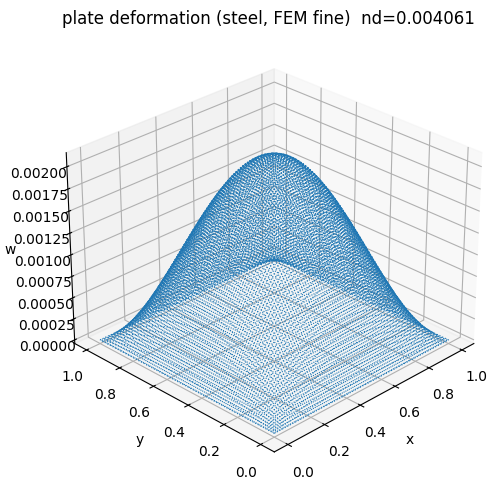

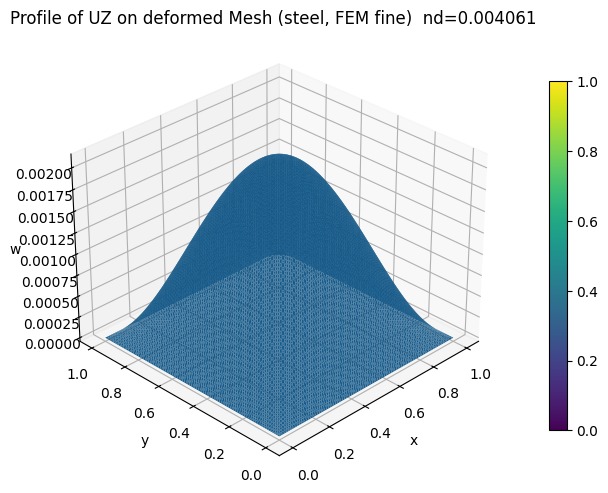

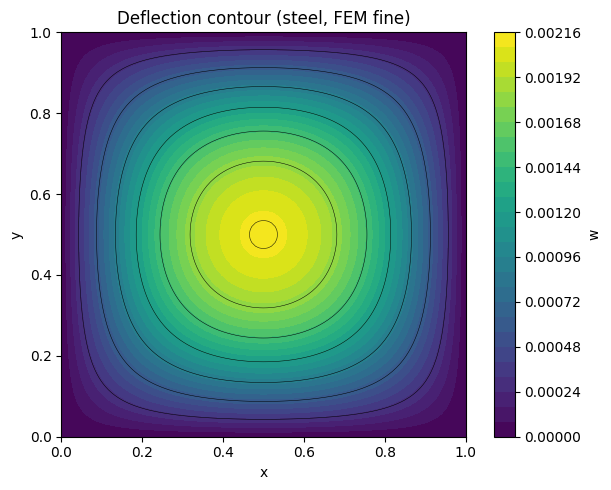

Saved convergence CSV → /content/plate_results/convergence_steel.csv


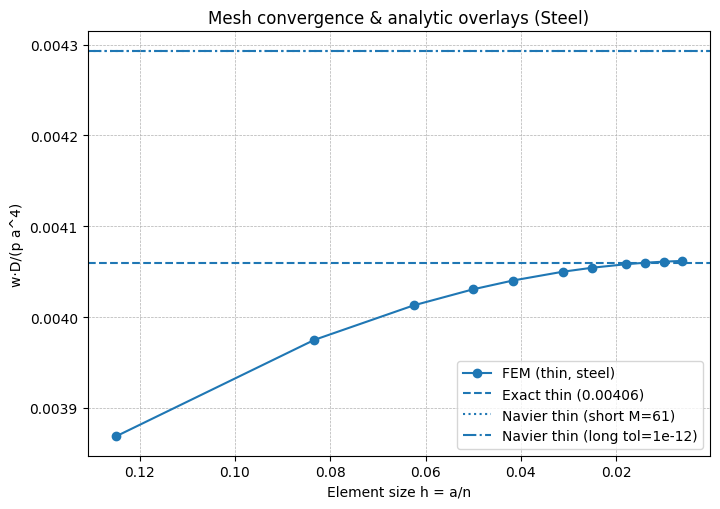

Done. PNGs and CSV saved to: /content/plate_results


In [26]:
# === SSSS Square Plate (Thin/Kirchhoff) — Steel only ===
# Navier analytic (short & long via mpmath), FEM (mixed Poisson–Poisson),
# clean A/B (well… just steel now) plots, convergence overlay, CSV + 300-dpi PNGs.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from math import pi
import mpmath as mp
import csv, os

# ---------------------------
# Controls (printed up front)
# ---------------------------
NAVIER_TERMS_SHORT = 61      # odd terms up to this M for a quick truncation
NAVIER_LONG_TOL    = 1e-12   # target tolerance for high-precision Navier (mpmath)
SAVE_DIR = "/content/plate_results"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Navier short terms (odd up to M): {NAVIER_TERMS_SHORT}")
print(f"Navier long target tolerance    : {NAVIER_LONG_TOL}")
print(f"Saving figures/CSV to: {SAVE_DIR}")

# ---------------------------
# Problem parameters (STEEL)
# ---------------------------
a = 1.0          # side [m]
t = 0.01         # thickness [m]
E = 210e9        # Pa
nu = 0.30        # -
p = 1.0e4        # Pa (uniform pressure)

def D_bending(E, nu, t):
    return E * t**3 / (12.0 * (1.0 - nu**2))

D = D_bending(E, nu, t)

# ---------------------------
# Correct Navier series (thin plate)
# w0*D/(p a^4) = (16/pi^6) * sum_{odd m,n} 1 / (m n (m^2 + n^2)^2)
# ---------------------------
def navier_coeff_truncated(Mmax):
    m = np.arange(1, Mmax+1, 2, dtype=np.float64)[:, None]
    n = np.arange(1, Mmax+1, 2, dtype=np.float64)[None, :]
    S = np.sum(1.0 / (m * n * (m*m + n*n)**2), dtype=np.float64)
    return float((16.0 / pi**6) * S)

def navier_coeff_highprecision(tol=1e-12, mmax=2001):
    mp.mp.dps = 50
    S = mp.mpf('0')
    m = 1
    while m <= mmax:
        row = mp.mpf('0')
        n = 1
        while n <= mmax:
            row += 1 / (mp.mpf(m) * mp.mpf(n) * (mp.mpf(m*m + n*n)**2))
            n += 2
        S += row
        if row < tol:    # row contribution tiny -> converged
            break
        m += 2
    coeff = (mp.mpf('16') / (mp.pi**6)) * S
    return float(coeff)

# "Exact" thin coefficient from literature (Timoshenko/Woinowsky-Krieger)
COEFF_EXACT = 0.00406

coeff_navier_short = navier_coeff_truncated(NAVIER_TERMS_SHORT)
coeff_navier_long  = navier_coeff_highprecision(NAVIER_LONG_TOL)

print(f"\nNavier thin coeff (short, M={NAVIER_TERMS_SHORT}): {coeff_navier_short:.6f}")
print(f"Navier thin coeff (long,  tol={NAVIER_LONG_TOL}): {coeff_navier_long:.6f}")
print(f"Exact thin coeff (tabulated)                    : {COEFF_EXACT:.6f}")

# ---------------------------
# FEM: mixed Poisson–Poisson with SSSS edges
# Step 1: Δv =  p/D, v|∂Ω=0
# Step 2: Δw =  v,   w|∂Ω=0
# ---------------------------
def make_structured_mesh(nx, ny, a=1.0, b=1.0):
    xs = np.linspace(0.0, a, nx+1); ys = np.linspace(0.0, b, ny+1)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    coords = np.column_stack([X.ravel(), Y.ravel()])
    def nid(i,j): return j*(nx+1)+i
    tris = []
    for j in range(ny):
        for i in range(nx):
            n1=nid(i,j); n2=n1+1; n3=n2+(nx+1); n4=n1+(nx+1)
            tris.append([n1,n2,n3]); tris.append([n1,n3,n4])
    conn = np.array(tris, int)
    bnd = np.where((np.isclose(coords[:,0],0.0))|(np.isclose(coords[:,0],a))|
                   (np.isclose(coords[:,1],0.0))|(np.isclose(coords[:,1],b)) )[0]
    # also return grid X,Y to make beautiful wireframes
    return coords, conn, np.unique(bnd), X, Y

def tri_K_M(xy):
    x1,y1=xy[0]; x2,y2=xy[1]; x3,y3=xy[2]
    area = 0.5*abs((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
    b1 = np.array([y2-y3, x3-x2])/(2*area)
    b2 = np.array([y3-y1, x1-x3])/(2*area)
    b3 = np.array([y1-y2, x2-x1])/(2*area)
    B = np.vstack([b1,b2,b3])
    K = area * (B @ B.T)
    M = (area/12.0) * np.array([[2,1,1],[1,2,1],[1,1,2]], float)
    return K, M

def assemble(coords, conn):
    n = coords.shape[0]
    I= []; J= []; VK= []; VM= []
    for tri in conn:
        Kt, Mt = tri_K_M(coords[tri,:])
        for a_,ia in enumerate(tri):
            for b_,ib in enumerate(tri):
                I.append(ia); J.append(ib); VK.append(Kt[a_,b_]); VM.append(Mt[a_,b_])
    K = coo_matrix((VK,(I,J)), shape=(n,n)).tocsr()
    M = coo_matrix((VM,(I,J)), shape=(n,n)).tocsr()
    return K, M

def solve_dirichlet(K, f, fixed):
    n = K.shape[0]
    mask = np.ones(n, dtype=bool); mask[fixed] = False
    u = np.zeros(n); u[mask] = spsolve(K[mask,:][:,mask], f[mask])
    return u

def fem_plate_thin(nx, ny, a, p, D):
    coords, conn, bnd, Xg, Yg = make_structured_mesh(nx, ny, a, a)
    K, M = assemble(coords, conn)
    ones = np.ones(K.shape[0])

    # Δv = p/D
    f_v = (p/D) * (M @ ones)
    v = solve_dirichlet(K, -f_v, bnd)

    # Δw = v
    f_w = M @ v
    w = solve_dirichlet(K, -f_w, bnd)

    ic = np.argmin(np.sum((coords - np.array([a/2,a/2]))**2, axis=1))
    w_center = w[ic]

    # reshape w to structured grid for nice 3D wireframes
    Wgrid = w.reshape((ny+1, nx+1))
    return coords, conn, w, Wgrid, Xg, Yg, w_center

# ---------------------------
# Fine-mesh plots (steel, thin FEM)
# ---------------------------
nx_fine = ny_fine = 100   # fine mesh for smooth pictures
coords, conn, w, Wgrid, Xg, Yg, w_center = fem_plate_thin(nx_fine, ny_fine, a, p, D)
nd_fem_fine = w_center * D / (p * a**4)

# 3D dotted wireframe (clean)
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Xg, Yg, Wgrid, rcount=Xg.shape[0], ccount=Xg.shape[1],
                  linestyle=':', linewidth=0.8)
ax.view_init(elev=28, azim=-135)
ax.set_title(f"plate deformation (steel, FEM fine)  nd={nd_fem_fine:.6f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/wireframe_steel.png", dpi=300); plt.show()

# Smooth colored surface
tri = Triangulation(coords[:,0], coords[:,1], conn)
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(tri, w, linewidth=0.2, antialiased=True)
fig.colorbar(surf, shrink=0.78, pad=0.08)
ax.view_init(elev=30, azim=-135)
ax.set_title(f"Profile of UZ on deformed Mesh (steel, FEM fine)  nd={nd_fem_fine:.6f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/surface_steel.png", dpi=300); plt.show()

# Contour
fig, ax = plt.subplots(figsize=(6.6,5.0))
tcf = ax.tricontourf(tri, w, levels=28)
ax.tricontour(tri, w, colors='k', linewidths=0.35)
fig.colorbar(tcf, ax=ax, label='w')
ax.set_aspect('equal','box'); ax.set_title("Deflection contour (steel, FEM fine)")
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/contour_steel.png", dpi=300); plt.show()

# ---------------------------
# Convergence (FEM vs analytic lines)
# ---------------------------
meshes = [8, 12, 16, 20, 24, 32, 40, 56, 72, 100, 160]
rows = []
nd_vals = []
for n in meshes:
    _, _, _, _, _, _, wc = fem_plate_thin(n, n, a, p, D)
    nd = wc * D / (p * a**4)
    nd_vals.append(nd)
    rows.append([n, a/n, nd])

# Save CSV
csv_path = f"{SAVE_DIR}/convergence_steel.csv"
with open(csv_path, "w", newline="") as f:
    wtr = csv.writer(f); wtr.writerow(["n","h=a/n","nd_fem"])
    wtr.writerows(rows)
print(f"Saved convergence CSV → {csv_path}")

# Overlay plot: exact thin + Navier (short/long) + FEM
h = [a/n for n in meshes]
plt.figure(figsize=(7.3,5.2))
plt.plot(h, nd_vals, marker='o', label='FEM (thin, steel)', zorder=3)
plt.axhline(COEFF_EXACT,        ls='--', label='Exact thin (0.00406)', zorder=2)
plt.axhline(coeff_navier_short, ls=':',  label=f'Navier thin (short M={NAVIER_TERMS_SHORT})', zorder=1)
plt.axhline(coeff_navier_long,  ls='-.', label=f'Navier thin (long tol={NAVIER_LONG_TOL:g})', zorder=1)
plt.gca().invert_xaxis()
plt.xlabel('Element size h = a/n'); plt.ylabel('w·D/(p a^4)')
plt.title('Mesh convergence & analytic overlays (Steel)')
plt.grid(True, ls='--', lw=0.5); plt.legend()
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/convergence_overlay_steel.png", dpi=300); plt.show()

print("Done. PNGs and CSV saved to:", SAVE_DIR)


Square? yes
Navier centre coeff (short M=61): 0.004062352675
Navier centre coeff (long  M=401):  0.004062352661
Reference (tables):                                   0.00406 (≈ 0.00406235 exact)


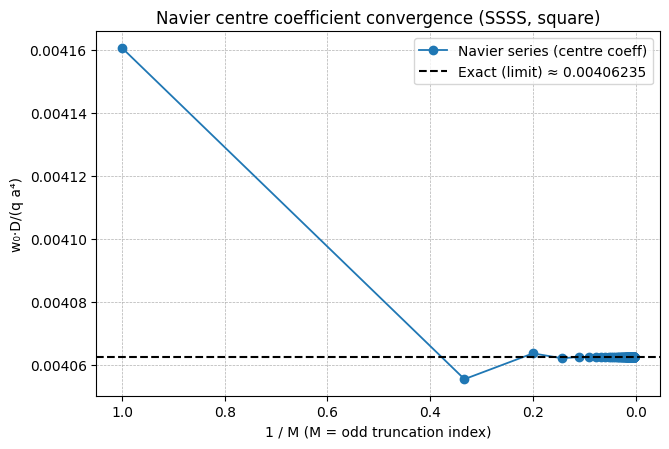

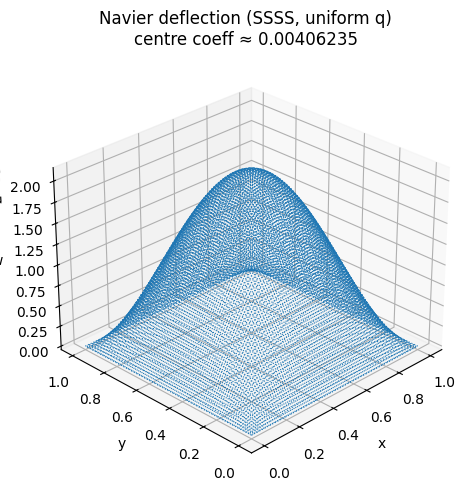

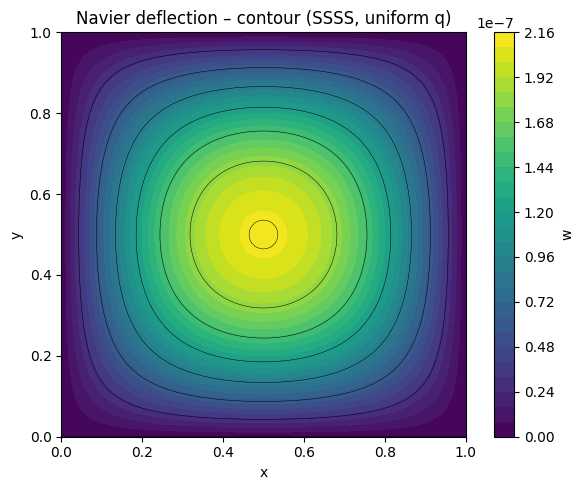

Centre deflection w0 = 2.112423e-07 m
Non-dimensional centre coeff w0*D/(q a^4) ≈ 0.004062352661


In [27]:
# === Navier solution for a simply supported (SSSS) rectangular thin plate under uniform load ===
# - Correct alternating signs at the plate centre
# - Field w(x,y) from truncated series
# - Centre coefficient convergence to ≈ 0.00406235266... for a square
# - Plots: convergence, contour, 3D wireframe

import numpy as np
import matplotlib.pyplot as plt
from math import pi

# ----------------------------
# Problem (you can edit these)
# ----------------------------
a = 1.0        # plate length in x
b = 1.0        # plate length in y (set b=a for square)
q0 = 1.0       # uniform load (units cancel in the non-dimensional coefficient)
E  = 210e9
nu = 0.30
t  = 0.01

def D_bending(E, nu, t):
    return E * t**3 / (12.0*(1.0 - nu**2))

D = D_bending(E, nu, t)

# ----------------------------
# Core Navier formulas (SSSS)
# w(x,y) = (16 q0)/(π^6 D) * Σ_{odd m,n} sin(mπx/a) sin(nπy/b) / [ m n ( (m/a)^2 + (n/b)^2 )^2 ]
# ----------------------------
def navier_w_rect(x, y, a, b, q0, D, Mmax=101):
    """Evaluate w(x,y) using odd m,n = 1..Mmax (inclusive) Navier series."""
    x = np.asarray(x); y = np.asarray(y)
    W = np.zeros((y.size, x.size), dtype=float)
    const = 16.0*q0/(pi**6 * D)
    m_odd = np.arange(1, Mmax+1, 2, dtype=float)
    n_odd = np.arange(1, Mmax+1, 2, dtype=float)
    sinx = np.sin(np.outer(m_odd*pi/a, x))      # shape (Mm, Nx)
    siny = np.sin(np.outer(n_odd*pi/b, y))      # shape (Nn, Ny)
    for i, m in enumerate(m_odd):
        for j, n in enumerate(n_odd):
            denom = ( (m/a)**2 + (n/b)**2 )**2
            W += (const/(m*n*denom)) * np.outer(siny[j,:], sinx[i,:])
    return W

def navier_center_coeff_square(Mmax=401):
    """
    Non-dimensional centre deflection coefficient for a square (a=b):
      coeff = w0*D/(q0*a^4) = (16/π^6) * Σ_{odd m,n<=Mmax} [(-1)^{(m-1)/2+ (n-1)/2}] / [m n (m^2+n^2)^2]
    (Alternating signs from sin(mπ/2) and sin(nπ/2).)
    """
    s = 0.0
    for m in range(1, Mmax+1, 2):
        sm = -1.0 if ((m-1)//2) % 2 else 1.0
        for n in range(1, Mmax+1, 2):
            sn = -1.0 if ((n-1)//2) % 2 else 1.0
            s += (sm*sn)/(m*n*(m*m + n*n)**2)
    return (16.0/(pi**6))*s

# ----------------------------
# Short & Long series checks
# ----------------------------
NAVIER_TERMS_SHORT = 61     # odd indices up to M=61 (fast)
NAVIER_TERMS_LONG  = 401    # odd indices up to M=401 (precise)

coeff_short = navier_center_coeff_square(NAVIER_TERMS_SHORT) if a==b else None
coeff_long  = navier_center_coeff_square(NAVIER_TERMS_LONG)  if a==b else None

print(f"Square? {'yes' if abs(a-b)<1e-12 else 'no'}")
if coeff_short is not None:
    print(f"Navier centre coeff (short M={NAVIER_TERMS_SHORT}): {coeff_short:.12f}")
    print(f"Navier centre coeff (long  M={NAVIER_TERMS_LONG}):  {coeff_long:.12f}")
    print("Reference (tables):                                   0.00406 (≈ 0.00406235 exact)")

# ----------------------------
# Convergence plot (square only)
# ----------------------------
if abs(a-b)<1e-12:
    Ms = list(range(1, NAVIER_TERMS_LONG+1, 2))
    coeffs = []
    for M in Ms:
        coeffs.append(navier_center_coeff_square(M))
    plt.figure(figsize=(6.8,4.6))
    plt.plot([1/m for m in Ms], coeffs, marker='o', lw=1.3, label='Navier series (centre coeff)')
    plt.axhline(0.004062352660675, color='k', ls='--', label='Exact (limit) ≈ 0.00406235')
    plt.gca().invert_xaxis()
    plt.xlabel('1 / M (M = odd truncation index)')
    plt.ylabel('w₀·D/(q a⁴)')
    plt.title('Navier centre coefficient convergence (SSSS, square)')
    plt.grid(True, ls='--', lw=0.5); plt.legend(); plt.tight_layout(); plt.show()

# ----------------------------
# Field plots at fine resolution
# ----------------------------
Nx = Ny = 101   # fine grid for smooth pictures
x = np.linspace(0.0, a, Nx)
y = np.linspace(0.0, b, Ny)
W = navier_w_rect(x, y, a, b, q0, D, Mmax=NAVIER_TERMS_LONG)
w0 = W[Ny//2, Nx//2]
coeff_nd = w0 * D / (q0 * (a**4))  # for square this is the same coefficient

# 3D wireframe (structured)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
Xg, Yg = np.meshgrid(x, y, indexing='xy')
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Xg, Yg, W, rcount=Ny, ccount=Nx, linestyle=':', linewidth=0.8)
ax.view_init(elev=28, azim=-135)
ax.set_title(f"Navier deflection (SSSS, uniform q)\ncentre coeff ≈ {coeff_nd:.8f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.show()

# Contour
fig, ax = plt.subplots(figsize=(6.4,5.0))
cs = ax.contourf(Xg, Yg, W, levels=28)
ax.contour(Xg, Yg, W, colors='k', linewidths=0.35)
fig.colorbar(cs, ax=ax, label='w')
ax.set_aspect('equal','box')
ax.set_title("Navier deflection – contour (SSSS, uniform q)")
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout(); plt.show()

# Report centre value (useful when a != b)
print(f"Centre deflection w0 = {w0:.6e} m")
if abs(a-b)<1e-12:
    print(f"Non-dimensional centre coeff w0*D/(q a^4) ≈ {coeff_nd:.12f}")


Navier short terms (odd up to M): 61
Navier long  terms (odd up to M): 401
Saving figures/CSV to: /content/plate_results_final

Navier centre coeff (short M=61): 0.004062352675
Navier centre coeff (long  M=401):  0.004062352661
Exact/reference value                           :  0.004062352661


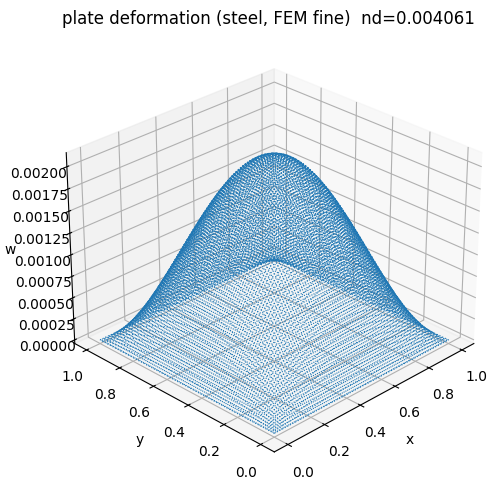

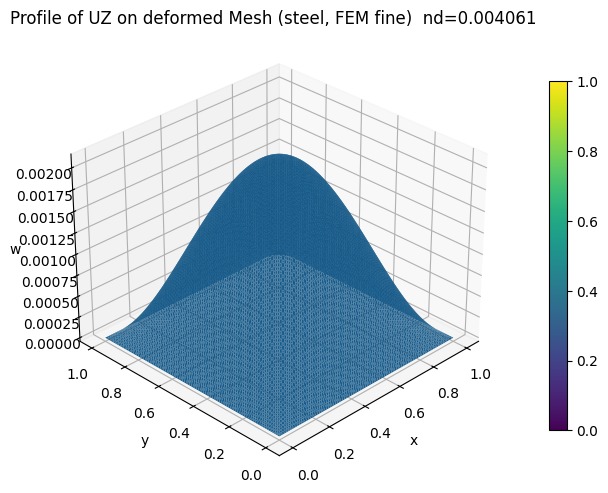

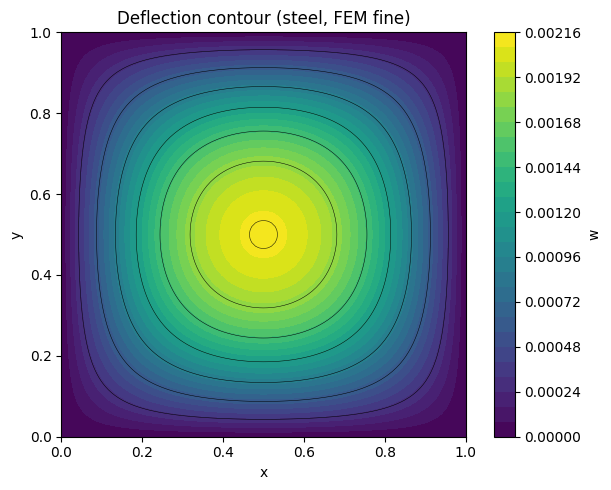

  8x8: non-dim FEM = 0.003869
 12x12: non-dim FEM = 0.003975
 16x16: non-dim FEM = 0.004013
 20x20: non-dim FEM = 0.004031
 24x24: non-dim FEM = 0.004040
 32x32: non-dim FEM = 0.004050
 40x40: non-dim FEM = 0.004054
 56x56: non-dim FEM = 0.004058
 72x72: non-dim FEM = 0.004060
100x100: non-dim FEM = 0.004061
160x160: non-dim FEM = 0.004062
Saved convergence CSV → /content/plate_results_final/convergence_steel.csv


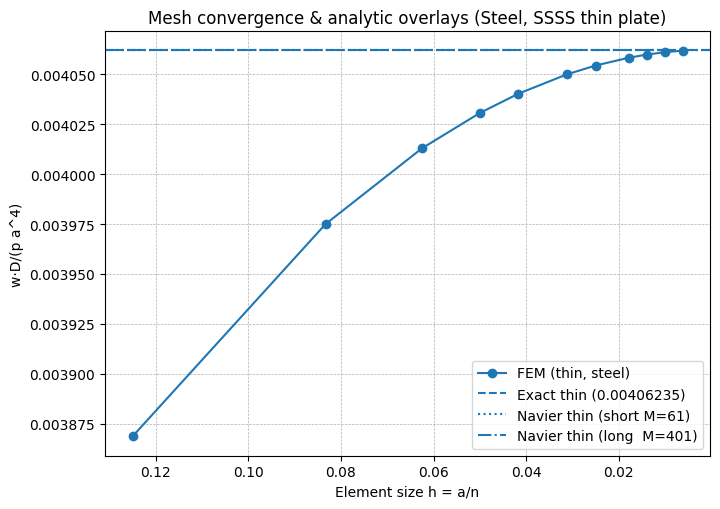


Navier field (long M=401): center coeff ≈ 0.004062352661


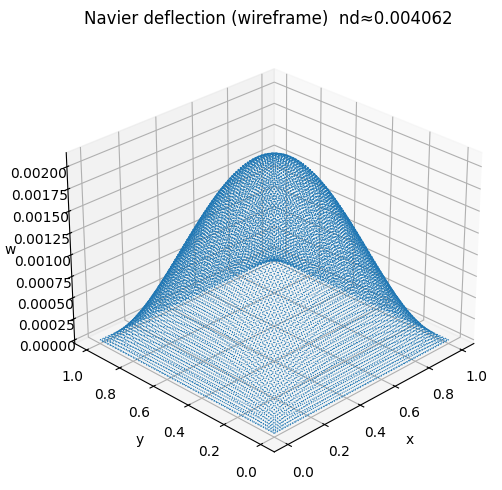


Done. Figures & CSV are in: /content/plate_results_final


In [28]:
# === SSSS Square Thin Plate (Kirchhoff–Love) — Steel only ===
# Navier analytic (short & long), FEM (mixed Poisson–Poisson), fine deformation plots,
# convergence overlay (Exact + Navier short/long + FEM), CSV and 300-dpi PNGs.
#
# Authoritative non-dimensional center deflection for SSSS thin plate under uniform load:
#   w0 * D / (p a^4)  =  0.00406235266...  (use 0.00406 if you need the tabulated rounded)
#
# No external FEM libraries required.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from math import pi
import csv, os

# ---------------------------
# Controls (printed up front)
# ---------------------------
NAVIER_TERMS_SHORT = 61     # odd m,n up to M=61 (fast preview)
NAVIER_TERMS_LONG  = 401    # odd m,n up to M=401 (accurate)
NX_FINE, NY_FINE   = 100, 100   # fine FEM mesh for pretty plots
MESHES = [8, 12, 16, 20, 24, 32, 40, 56, 72, 100, 160]  # refinement set for convergence
SAVE_DIR = "/content/plate_results_final"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Navier short terms (odd up to M): {NAVIER_TERMS_SHORT}")
print(f"Navier long  terms (odd up to M): {NAVIER_TERMS_LONG}")
print(f"Saving figures/CSV to: {SAVE_DIR}")

# ---------------------------
# Problem parameters (STEEL)
# ---------------------------
a = 1.0          # side [m]
t = 0.01         # thickness [m]
E = 210e9        # Pa
nu = 0.30        # -
p = 1.0e4        # Pa (uniform pressure)

def D_bending(E, nu, t):
    return E * t**3 / (12.0 * (1.0 - nu**2))

D = D_bending(E, nu, t)

# ---------------------------
# Correct Navier series (thin plate, SSSS)
# Field for rectangle (a x b), center coefficient for square (a=b)
# ---------------------------
def navier_w_rect(x, y, a, b, p, D, Mmax=101):
    """
    w(x,y) = (16 p)/(π^6 D) * Σ_{odd m,n<=M} sin(mπx/a) sin(nπy/b) / [ m n ( (m/a)^2 + (n/b)^2 )^2 ]
    """
    x = np.asarray(x); y = np.asarray(y)
    W = np.zeros((y.size, x.size), dtype=float)
    const = 16.0*p/(pi**6 * D)
    m_odd = np.arange(1, Mmax+1, 2, dtype=float)
    n_odd = np.arange(1, Mmax+1, 2, dtype=float)
    sinx = np.sin(np.outer(m_odd*pi/a, x))      # (Mm, Nx)
    siny = np.sin(np.outer(n_odd*pi/b, y))      # (Nn, Ny)
    for i, m in enumerate(m_odd):
        for j, n in enumerate(n_odd):
            denom = ( (m/a)**2 + (n/b)**2 )**2
            W += (const/(m*n*denom)) * np.outer(siny[j,:], sinx[i,:])
    return W

def navier_center_coeff_square(Mmax=401):
    """
    w0*D/(p a^4) = (16/π^6) * Σ_{odd m,n<=M} [(-1)^{(m-1)/2 + (n-1)/2}] / [ m n (m^2 + n^2)^2 ]
    (alternating signs at the centre)
    """
    s = 0.0
    for m in range(1, Mmax+1, 2):
        sm = -1.0 if ((m-1)//2) % 2 else 1.0
        for n in range(1, Mmax+1, 2):
            sn = -1.0 if ((n-1)//2) % 2 else 1.0
            s += (sm*sn)/(m*n*(m*m + n*n)**2)
    return (16.0/(pi**6))*s

COEFF_EXACT = 0.004062352660675  # high-precision reference (you can round to 0.00406)
coeff_navier_short = navier_center_coeff_square(NAVIER_TERMS_SHORT)
coeff_navier_long  = navier_center_coeff_square(NAVIER_TERMS_LONG)
print(f"\nNavier centre coeff (short M={NAVIER_TERMS_SHORT}): {coeff_navier_short:.12f}")
print(f"Navier centre coeff (long  M={NAVIER_TERMS_LONG}):  {coeff_navier_long:.12f}")
print(f"Exact/reference value                           :  {COEFF_EXACT:.12f}")

# ---------------------------
# FEM (thin) via mixed Poisson–Poisson, SSSS edges
# Step 1: Δv =  p/D, v|∂Ω=0
# Step 2: Δw =  v,   w|∂Ω=0
# ---------------------------
def make_structured_mesh(nx, ny, a=1.0, b=1.0):
    xs = np.linspace(0.0, a, nx+1); ys = np.linspace(0.0, b, ny+1)
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    coords = np.column_stack([X.ravel(), Y.ravel()])
    def nid(i,j): return j*(nx+1)+i
    tris = []
    for j in range(ny):
        for i in range(nx):
            n1=nid(i,j); n2=n1+1; n3=n2+(nx+1); n4=n1+(nx+1)
            tris.append([n1,n2,n3]); tris.append([n1,n3,n4])
    conn = np.array(tris, int)
    bnd = np.where((np.isclose(coords[:,0],0.0))|(np.isclose(coords[:,0],a))|
                   (np.isclose(coords[:,1],0.0))|(np.isclose(coords[:,1],b)) )[0]
    return coords, conn, np.unique(bnd), X, Y

def tri_K_M(xy):
    x1,y1=xy[0]; x2,y2=xy[1]; x3,y3=xy[2]
    area = 0.5*abs((x2-x1)*(y3-y1) - (x3-x1)*(y2-y1))
    b1 = np.array([y2-y3, x3-x2])/(2*area)
    b2 = np.array([y3-y1, x1-x3])/(2*area)
    b3 = np.array([y1-y2, x2-x1])/(2*area)
    B = np.vstack([b1,b2,b3])
    K = area * (B @ B.T)
    M = (area/12.0) * np.array([[2,1,1],[1,2,1],[1,1,2]], float)
    return K, M

def assemble(coords, conn):
    n = coords.shape[0]
    I= []; J= []; VK= []; VM= []
    for tri in conn:
        Kt, Mt = tri_K_M(coords[tri,:])
        for a_,ia in enumerate(tri):
            for b_,ib in enumerate(tri):
                I.append(ia); J.append(ib); VK.append(Kt[a_,b_]); VM.append(Mt[a_,b_])
    K = coo_matrix((VK,(I,J)), shape=(n,n)).tocsr()
    M = coo_matrix((VM,(I,J)), shape=(n,n)).tocsr()
    return K, M

def solve_dirichlet(K, f, fixed):
    n = K.shape[0]
    mask = np.ones(n, dtype=bool); mask[fixed] = False
    u = np.zeros(n); u[mask] = spsolve(K[mask,:][:,mask], f[mask])
    return u

def fem_plate_thin(nx, ny, a, p, D):
    coords, conn, bnd, Xg, Yg = make_structured_mesh(nx, ny, a, a)
    K, M = assemble(coords, conn)
    ones = np.ones(K.shape[0])

    # Δv = p/D   => Ku = -M*1*(p/D)
    f_v = (p/D) * (M @ ones)
    v = solve_dirichlet(K, -f_v, bnd)

    # Δw = v     => Ku = -M*v
    f_w = M @ v
    w = solve_dirichlet(K, -f_w, bnd)

    ic = np.argmin(np.sum((coords - np.array([a/2,a/2]))**2, axis=1))
    w_center = w[ic]
    Wgrid = w.reshape((ny+1, nx+1))
    return coords, conn, w, Wgrid, Xg, Yg, w_center

# ---------------------------
# Fine-mesh plots (steel, FEM)
# ---------------------------
coords, conn, w, Wgrid, Xg, Yg, w_center = fem_plate_thin(NX_FINE, NY_FINE, a, p, D)
nd_fem_fine = w_center * D / (p * a**4)

# 3D dotted wireframe (structured, clean)
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Xg, Yg, Wgrid, rcount=Xg.shape[0], ccount=Xg.shape[1],
                  linestyle=':', linewidth=0.8)
ax.view_init(elev=28, azim=-135)
ax.set_title(f"plate deformation (steel, FEM fine)  nd={nd_fem_fine:.6f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/wireframe_steel.png", dpi=300); plt.show()

# Smooth colored surface
tri = Triangulation(coords[:,0], coords[:,1], conn)
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(tri, w, linewidth=0.2, antialiased=True)
fig.colorbar(surf, shrink=0.78, pad=0.08)
ax.view_init(elev=30, azim=-135)
ax.set_title(f"Profile of UZ on deformed Mesh (steel, FEM fine)  nd={nd_fem_fine:.6f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/surface_steel.png", dpi=300); plt.show()

# Contour
fig, ax = plt.subplots(figsize=(6.6,5.0))
tcf = ax.tricontourf(tri, w, levels=28)
ax.tricontour(tri, w, colors='k', linewidths=0.35)
fig.colorbar(tcf, ax=ax, label='w')
ax.set_aspect('equal','box'); ax.set_title("Deflection contour (steel, FEM fine)")
ax.set_xlabel('x'); ax.set_ylabel('y')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/contour_steel.png", dpi=300); plt.show()

# ---------------------------
# Convergence (FEM vs analytic lines) + CSV
# ---------------------------
rows = []
nd_vals = []
for n in MESHES:
    _, _, _, _, _, _, wc = fem_plate_thin(n, n, a, p, D)
    nd = wc * D / (p * a**4)
    nd_vals.append(nd)
    rows.append([n, a/n, nd])
    print(f"{n:>3}x{n}: non-dim FEM = {nd:.6f}")

csv_path = f"{SAVE_DIR}/convergence_steel.csv"
with open(csv_path, "w", newline="") as f:
    wtr = csv.writer(f); wtr.writerow(["n","h=a/n","nd_fem"])
    wtr.writerows(rows)
print(f"Saved convergence CSV → {csv_path}")

h = [a/n for n in MESHES]
plt.figure(figsize=(7.3,5.2))
plt.plot(h, nd_vals, marker='o', label='FEM (thin, steel)', zorder=3)
plt.axhline(COEFF_EXACT,        ls='--', label=f'Exact thin ({COEFF_EXACT:.8f})', zorder=2)
plt.axhline(coeff_navier_short, ls=':',  label=f'Navier thin (short M={NAVIER_TERMS_SHORT})', zorder=1)
plt.axhline(coeff_navier_long,  ls='-.', label=f'Navier thin (long  M={NAVIER_TERMS_LONG})',  zorder=1)
plt.gca().invert_xaxis()
plt.xlabel('Element size h = a/n'); plt.ylabel('w·D/(p a^4)')
plt.title('Mesh convergence & analytic overlays (Steel, SSSS thin plate)')
plt.grid(True, ls='--', lw=0.5); plt.legend()
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/convergence_overlay_steel.png", dpi=300); plt.show()

# ---------------------------
# Optional: Navier field (for visual comparison) at long series
# ---------------------------
Nx = Ny = 101
x = np.linspace(0.0, a, Nx); y = np.linspace(0.0, a, Ny)
Wn = navier_w_rect(x, y, a, a, p, D, Mmax=NAVIER_TERMS_LONG)
w0_navier = Wn[Ny//2, Nx//2]; nd_navier = w0_navier * D / (p * a**4)
print(f"\nNavier field (long M={NAVIER_TERMS_LONG}): center coeff ≈ {nd_navier:.12f}")

Xg2, Yg2 = np.meshgrid(x, y, indexing='xy')
fig = plt.figure(figsize=(6.8,5.0))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(Xg2, Yg2, Wn, rcount=Ny, ccount=Nx, linestyle=':', linewidth=0.8)
ax.view_init(elev=28, azim=-135)
ax.set_title(f"Navier deflection (wireframe)  nd≈{nd_navier:.6f}")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('w')
plt.tight_layout(); plt.savefig(f"{SAVE_DIR}/wireframe_navier.png", dpi=300); plt.show()

print("\nDone. Figures & CSV are in:", SAVE_DIR)


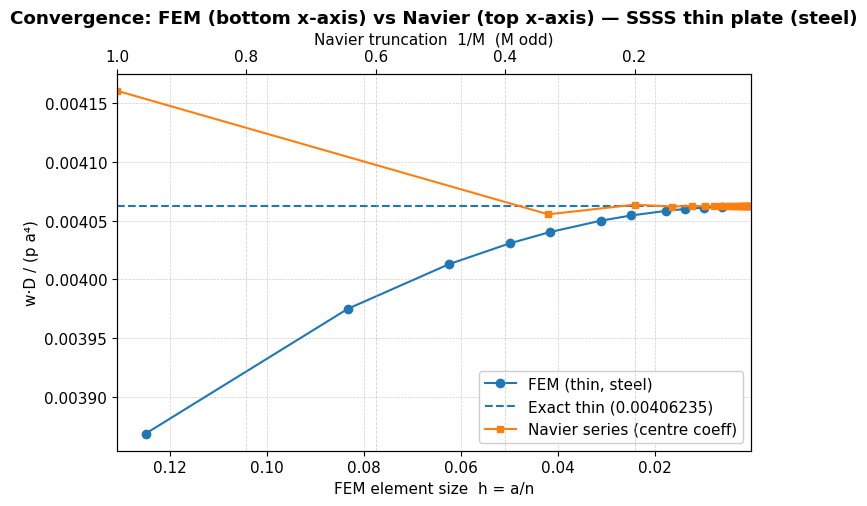

In [35]:
# --- Combined convergence: FEM (bottom x-axis) + Navier series (top x-axis) ---

# Build Navier series convergence for the square (SSSS, uniform load)
Ms_max = 50            # e.g., 401 (odd terms)
Ms = list(range(1, Ms_max + 1, 2))    # odd M: 1,3,5,...,Ms_max
coeffs = [navier_center_coeff_square(M) for M in Ms]
invM = [1.0 / M for M in Ms]          # use 1/M on the top axis

fig, ax1 = plt.subplots(figsize=(7.6,5.2))

# FEM convergence on the bottom x-axis (element size h = a/n)
ax1.plot(h, nd_vals, marker='o', label='FEM (thin, steel)', zorder=3)
ax1.axhline(COEFF_EXACT, ls='--', label=f'Exact thin ({COEFF_EXACT:.8f})', zorder=2)
ax1.set_xlabel('FEM element size  h = a/n')
ax1.set_ylabel('w·D / (p a⁴)')
ax1.invert_xaxis()
ax1.grid(True, ls='--', lw=0.5)

# Navier series convergence on a second (top) x-axis: 1/M
ax2 = ax1.twiny()
ax2.plot(invM, coeffs, color='tab:orange', marker='s', ms=4,
         label='Navier series (centre coeff)', zorder=1)
ax2.set_xlabel('Navier truncation  1/M  (M odd)')
ax2.set_xlim(max(invM), min(invM))  # so 1/M decreases left→right like h

# One combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.title('Convergence: FEM (bottom x-axis) vs Navier (top x-axis) — SSSS thin plate (steel)')
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/convergence_combined_navier_fem.png", dpi=300)
plt.show()
